<a href="https://colab.research.google.com/github/rugvedbairagi26/ChestX-ray/blob/main/Chestx_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rugvedbairagi","key":"2efa0866d7ef2c3b0a69fa94cd6a8ae1"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets files nih-chest-xrays/data


Next Page Token = CfDJ8EjpvNnYgNtGoWS2kk3rGCLY4IQa6B8IZ-rTQZb8jop4PnICVOt3iS0lIBAgXiYXJwmsPgyqGluXulQAj1ClKpc
name                                   size  creationDate                
----------------------------------  -------  --------------------------  
ARXIV_V5_CHESTXRAY.pdf              8963138  2019-09-24 23:56:19.481000  
BBox_List_2017.csv                    92416  2019-09-24 23:56:19.362000  
Data_Entry_2017.csv                 7861152  2019-09-24 23:56:19.543000  
FAQ_CHESTXRAY.pdf                     72223  2019-09-24 23:56:19.721000  
LOG_CHESTXRAY.pdf                      3919  2019-09-24 23:56:19.430000  
README_CHESTXRAY.pdf                 847223  2019-09-24 23:56:19.407000  
images_001/images/00000001_000.png   457171  2018-02-21 23:57:46.601000  
images_001/images/00000001_001.png   444655  2018-02-21 23:56:51.890000  
images_001/images/00000001_002.png   351772  2018-02-21 23:58:27.109000  
images_001/images/00000002_000.png   402332  2018-02-21 23:56:53.013000  
im

In [4]:
!kaggle datasets download -d nih-chest-xrays/data -p /content/nih_dataset


Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/data
License(s): CC0-1.0
100% 41.9G/42.0G [02:09<00:06, 18.6MB/s]
100% 42.0G/42.0G [02:09<00:00, 348MB/s] 


In [5]:
!unzip -q /content/nih_dataset/data.zip -d /content/nih_dataset/


In [6]:
!ls /content/nih_dataset/


ARXIV_V5_CHESTXRAY.pdf	images_002  images_008	       README_CHESTXRAY.pdf
BBox_List_2017.csv	images_003  images_009	       test_list.txt
Data_Entry_2017.csv	images_004  images_010	       train_val_list.txt
data.zip		images_005  images_011
FAQ_CHESTXRAY.pdf	images_006  images_012
images_001		images_007  LOG_CHESTXRAY.pdf


In [8]:
import os

base_dir = '/content/nih_dataset'
print(os.path.exists(base_dir))  # Should return True if base dir is correct

print(os.listdir(base_dir))      # View folder contents


True
['README_CHESTXRAY.pdf', 'images_011', 'test_list.txt', 'images_009', 'BBox_List_2017.csv', 'data.zip', 'images_004', 'images_002', 'images_005', 'images_003', 'images_012', 'Data_Entry_2017.csv', 'LOG_CHESTXRAY.pdf', 'images_008', 'ARXIV_V5_CHESTXRAY.pdf', 'images_001', 'train_val_list.txt', 'images_010', 'FAQ_CHESTXRAY.pdf', 'images_007', 'images_006']


In [9]:
import os
import pandas as pd

BASE_DIR = '/content/nih_dataset' # Your dataset base directory
csv_path = os.path.join(BASE_DIR, 'Data_Entry_2017.csv')
df = pd.read_csv(csv_path)

all_image_paths = {}

# Recursively scan all image folders for image files
for folder in sorted([f for f in os.listdir(BASE_DIR) if f.startswith('images_')]):
    folder_path = os.path.join(BASE_DIR, folder)
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                all_image_paths[file] = os.path.join(root, file)

print(f"Total images found: {len(all_image_paths)}")

# Map these full image paths back to the dataframe using the image filename
df['filepath'] = df['Image Index'].map(all_image_paths)

missing = df['filepath'].isnull().sum()
print(f"Number of missing images after full scan: {missing}")

# Check first few rows to confirm
print(df[['filepath', 'Finding Labels']].head())

Total images found: 112120
Number of missing images after full scan: 0
                                            filepath          Finding Labels
0  /content/nih_dataset/images_001/images/0000000...            Cardiomegaly
1  /content/nih_dataset/images_001/images/0000000...  Cardiomegaly|Emphysema
2  /content/nih_dataset/images_001/images/0000000...   Cardiomegaly|Effusion
3  /content/nih_dataset/images_001/images/0000000...              No Finding
4  /content/nih_dataset/images_001/images/0000000...                  Hernia


In [10]:
# Core Libraries
import numpy as np
import pandas as pd
import os
import random
import gc # Garbage Collector

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split



print("TensorFlow Version:", tf.__version__)
print("All libraries imported successfully.")

TensorFlow Version: 2.19.0
All libraries imported successfully.


In [11]:
DISEASES = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
            'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
            'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

for disease in DISEASES:
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)

print("Sample one-hot encoded labels:")
print(df[DISEASES].head())

Sample one-hot encoded labels:
   Atelectasis  Cardiomegaly  Effusion  Infiltration  Mass  Nodule  Pneumonia  \
0            0             1         0             0     0       0          0   
1            0             1         0             0     0       0          0   
2            0             1         1             0     0       0          0   
3            0             0         0             0     0       0          0   
4            0             0         0             0     0       0          0   

   Pneumothorax  Consolidation  Edema  Emphysema  Fibrosis  \
0             0              0      0          0         0   
1             0              0      0          1         0   
2             0              0      0          0         0   
3             0              0      0          0         0   
4             0              0      0          0         0   

   Pleural_Thickening  Hernia  
0                   0       0  
1                   0       0  
2            

In [12]:

# Split unique patients for clean set separation
patients = df['Patient ID'].unique()

train_patients, temp_patients = train_test_split(patients, test_size=0.2, random_state=42)
val_patients, test_patients = train_test_split(temp_patients, test_size=0.5, random_state=42)

train_df = df[df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = df[df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = df[df['Patient ID'].isin(test_patients)].reset_index(drop=True)

print(f"Train: {train_df.shape[0]} samples, Val: {val_df.shape[0]}, Test: {test_df.shape[0]}")

Train: 89826 samples, Val: 10930, Test: 11364


In [13]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    brightness_range=[0.7, 1.3]
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Use flow_from_dataframe to feed images and labels from the DataFrames
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col=DISEASES,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col=DISEASES,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)


Found 89826 validated image filenames.
Found 10930 validated image filenames.


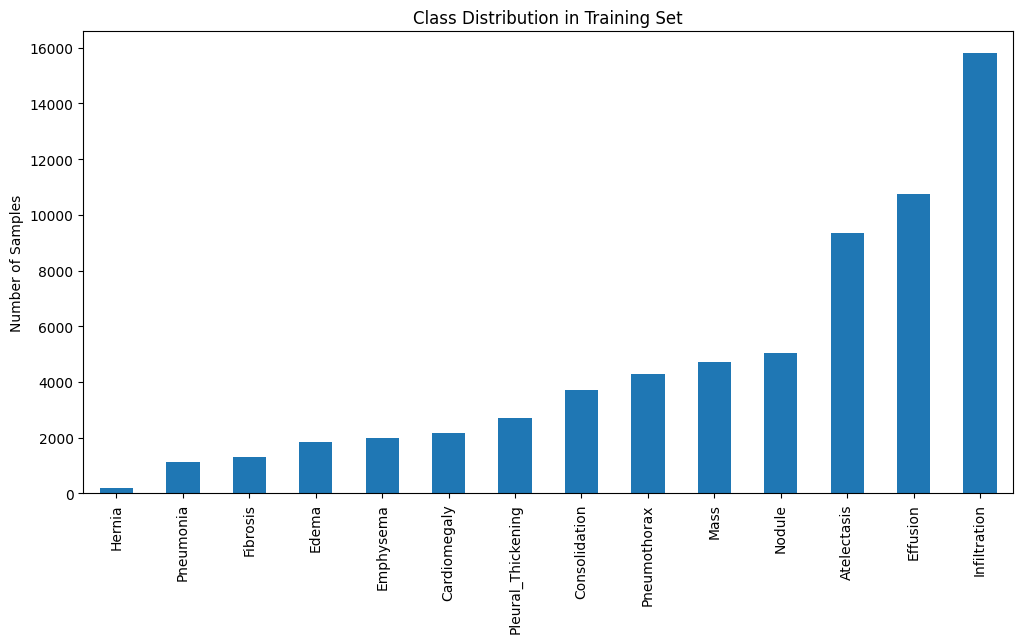

Class distribution (number of positive samples per disease):
Hernia                  179
Pneumonia              1137
Fibrosis               1322
Edema                  1849
Emphysema              1985
Cardiomegaly           2158
Pleural_Thickening     2725
Consolidation          3716
Pneumothorax           4282
Mass                   4706
Nodule                 5051
Atelectasis            9352
Effusion              10764
Infiltration          15797
dtype: int64


In [14]:
import matplotlib.pyplot as plt

label_sums = train_df[DISEASES].sum().sort_values()

plt.figure(figsize=(12,6))
label_sums.plot(kind='bar')
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Samples")
plt.show()

print("Class distribution (number of positive samples per disease):")
print(label_sums)

In [15]:
from tensorflow.keras.optimizers import Adam
# Load pretrained DenseNet121 excluding the top layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
outputs = Dense(len(DISEASES), activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=outputs)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
from sklearn.utils import class_weight
import numpy as np

# Calculate class weights for each disease

class_weights = {}

for i, disease in enumerate(DISEASES):
    labels = train_df[disease].values
    class_weights[i] = class_weight.compute_class_weight('balanced', classes=np.array([0,1]), y=labels)

print("Class weights per disease:\n", class_weights)

Class weights per disease:
 {0: array([0.55810572, 4.80250214]), 1: array([ 0.5123078 , 20.81232623]), 2: array([0.56807316, 4.17251951]), 3: array([0.60669467, 2.84313477]), 4: array([0.52764333, 9.54377391]), 5: array([0.52979062, 8.89190259]), 6: array([ 0.50641004, 39.50131926]), 7: array([ 0.52502806, 10.48879028]), 8: array([ 0.52157705, 12.08638321]), 9: array([ 0.51050843, 24.29042726]), 10: array([ 0.51129882, 22.62619647]), 11: array([ 0.50746859, 33.97352496]), 12: array([ 0.51564276, 16.48183486]), 13: array([  0.50099836, 250.91061453])}


In [18]:
import tensorflow as tf

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        eps = 1e-9
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma) * y_true + (1 - alpha) * tf.math.pow(y_pred, gamma) * (1 - y_true)
        loss = weight * cross_entropy
        return tf.reduce_mean(loss)
    return focal_loss_fixed

In [19]:
model.compile(optimizer=Adam(1e-4), loss=focal_loss(), metrics=['accuracy'])

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,051,854 (26.90 MB)

 Trainable params: 6,968,206 (26.58 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_densenet_model.h5', save_best_only=True, monitor='val_loss')


In [23]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=8,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/8
2808/2808 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.1947 - loss: 0.0192

2808/2808 ━━━━━━━━━━━━━━━━━━━━ 2405s 856ms/step - accuracy: 0.1947 - loss: 0.0192 - val_accuracy: 0.2754 - val_loss: 0.0152
Epoch 2/8
2808/2808 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.2376 - loss: 0.0170

2808/2808 ━━━━━━━━━━━━━━━━━━━━ 2383s 849ms/step - accuracy: 0.2376 - loss: 0.0170 - val_accuracy: 0.2109 - val_loss: 0.0152
Epoch 3/8
2808/2808 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.2463 - loss: 0.0163

2808/2808 ━━━━━━━━━━━━━━━━━━━━ 2376s 846ms/step - accuracy: 0.2463 - loss: 0.0163 - val_accuracy: 0.2122 - val_loss: 0.0148
Epoch 4/8
2808/2808 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.2547 - loss: 0.0156

2808/2808 ━━━━━━━━━━━━━━━━━━━━ 2379s 847ms/step - accuracy: 0.2547 - loss: 0.0156 - val_accuracy: 0.2126 - val_loss: 0.0146
Epoch 5/8
2808/2808 ━━━━━━━━━━━━━━━━━━━━ 2377s 846ms/step - accuracy: 0.2607 - loss: 0.0153 - val_accuracy: 0.2106 - val_loss: 0.0157
Epoch 6/8
2808/2808 ━━━━━━━━━━━━━━━━━━━━ 2369s 844ms/step - accuracy: 0.2672 - loss: 0.0148 - val_accuracy: 0.2126 - val_loss: 0.0149
Epoch 7/8
2808/2808 ━━━━━━━━━━━━━━━━━━━━ 2378s 847ms/step - accuracy: 0.2652 - loss: 0.0146 - val_accuracy: 0.2166 - val_loss: 0.0151
Epoch 8/8
2808/2808 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.2710 - loss: 0.0144

2808/2808 ━━━━━━━━━━━━━━━━━━━━ 2377s 847ms/step - accuracy: 0.2710 - loss: 0.0144 - val_accuracy: 0.3001 - val_loss: 0.0143


In [24]:
model.save('my_model.keras')


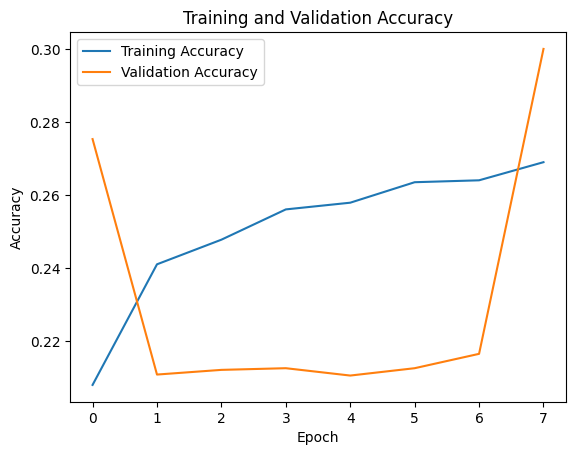

In [28]:
import matplotlib.pyplot as plt

# Assuming you saved the model history in a variable named history after model.fit()
# history.history contains keys like 'accuracy' and 'val_accuracy'

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



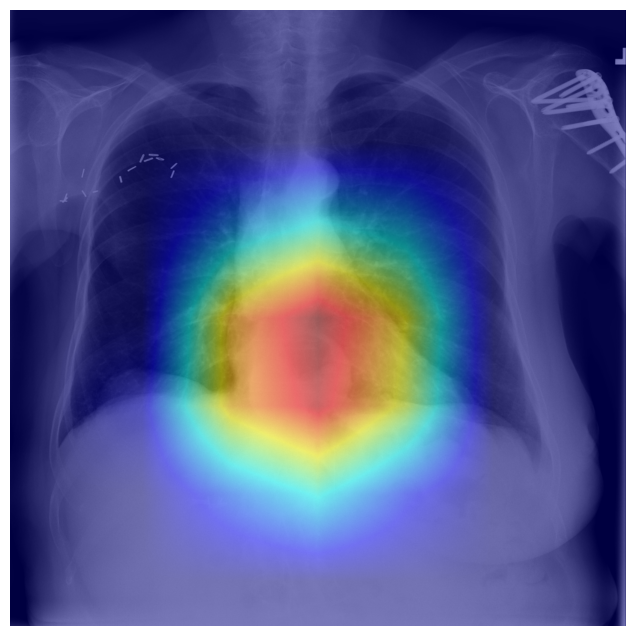

In [33]:


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap_on_image(img_path, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    # Load original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap to same size as image
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)

    # Apply colormap to heatmap
    heatmap_color = cv2.applyColorMap(heatmap_uint8, colormap)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Superimpose heatmap on original image
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)

    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Example usage:

img_path = '/content/nih_dataset/images_001/images/00000003_000.png'  # your image path here
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # preprocess

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='relu')  # update layer name if needed
overlay_heatmap_on_image(img_path, heatmap, alpha=0.5)